In [1]:
%matplotlib inline

# Preprocessing and LFP Plotting

## TODO: Add the preprocessing steps from https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.94_May2022/SpikeInterface_Tutorial.ipynb

# References

In [2]:
channel_id_to_brain_region = {"13": "LH", "14": "BLA", "15": "vHPC", "16":"MD", "21": "mPFC"}

In [3]:
trial_type_to_color = {"rewarded": "#FFAF00", "win": "#15616F", "omission": "#001424", "loss": "#792910"}

In [4]:
subject_id = "6.1"

# Chapter 2: Preprocessing Recording

In [5]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import importlib
from os.path import dirname
import itertools

In [6]:
from collections import defaultdict
import time
import json

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from scipy import stats

In [8]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [9]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [10]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_3599162/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [11]:
import spikeinterface.core

In [12]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [13]:
import spikeinterface.full as si

In [14]:
from spectral_connectivity import Multitaper, Connectivity



# Part 1: Importing Data

In [15]:
baseline_df_paths = glob.glob("./**/proc/*baseline*.pickle", recursive=True)

In [16]:
baseline_df_paths

['./subject_6_1/20221215/proc/baseline_20221215_145401_comp_amd_om_6_1_top_4_base_3.pickle',
 './subject_6_1/20221214/proc/baseline_20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.pickle']

In [17]:
trial_df_paths = glob.glob("./**/proc/*trial*.pickle", recursive=True)

In [18]:
trial_df_paths

['./subject_6_1/20221215/proc/trial_20221215_145401_comp_amd_om_6_1_top_4_base_3.pickle',
 './subject_6_1/20221214/proc/trial_20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.pickle']

In [19]:
resetted_index_to_column = {"level_0": "channel", "level_1": "trial_type"}

In [20]:
baseline_dataframe_list = [pd.read_pickle(path).reset_index().rename(columns=resetted_index_to_column) for path in baseline_df_paths]
trial_dataframe_list = [pd.read_pickle(path).reset_index().rename(columns=resetted_index_to_column) for path in trial_df_paths]


In [38]:
baseline_dataframe_list[0].head()

,channel,trial_type,power_list,frequency_list,traces_array,mean_traces_array,ste_traces_array
0,13,win,"[[118.75729700910028, 560.7193258170122, 1125....","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[118.75729700910028, 560.7193258170122, 1125....","[35.60484670296341, 126.07697117928228, 339.08...","[6.499305163583836, 28.888259183086173, 55.000..."
1,13,loss,"[[123.2893816996823, 183.62605814414778, 231.8...","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[123.2893816996823, 183.62605814414778, 231.8...","[123.2893816996823, 183.62605814414778, 231.84...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,13,rewarded,"[[121.65699096907213, 153.72494625114535, 302....","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[121.65699096907213, 153.72494625114535, 302....","[54.64499798271351, 93.77559601980418, 282.944...","[12.281893723972402, 16.531965755169956, 72.41..."
3,13,omission,"[[67.08440194203087, 245.44811877758343, 552.4...","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[67.08440194203087, 245.44811877758343, 552.4...","[105.38996184612036, 244.1961883738248, 420.93...","[44.95769610927939, 49.784048768123725, 131.77..."
4,14,win,"[[134.87388736962075, 478.44464897851816, 1501...","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[134.87388736962075, 478.44464897851816, 1501...","[98.36551384730343, 273.3778970022016, 778.415...","[25.717010793036206, 55.63209306725612, 148.93..."


# Part 2: Aggregating the power lists

In [40]:
ch_trial_df.head()

,channel,trial_type,power_list,frequency_list,traces_array,mean_traces_array,ste_traces_array
17,21,omission,"[[53.34523878113102, 141.17794167817692, 291.1...","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[53.34523878113102, 141.17794167817692, 291.1...","[92.31535057955013, 173.5650085056734, 612.441...","[26.808198491472275, 51.41011549240377, 274.56..."


In [41]:
baseline_channel_to_trial_to_power = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
# Goinf through each channel and trial type
for channel, trial_type in itertools.product(baseline_dataframe_list[0]["channel"].unique(), baseline_dataframe_list[0]["trial_type"].unique()):
    print("Channel: {} Trial Type: {}".format(channel, trial_type))
    for index, current_df in enumerate(baseline_dataframe_list):
        print("Dataframe Index: {}".format(index))
        ch_trial_df = current_df[(current_df["channel"] == channel) & (current_df["trial_type"] == trial_type)]
        baseline_channel_to_trial_to_power[channel][trial_type]["all_traces"].append(ch_trial_df["traces_array"].iloc[0])
    baseline_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"] = np.concatenate(baseline_channel_to_trial_to_power[channel][trial_type]["all_traces"])
    baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"] = np.mean(baseline_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"], axis = 0)
    baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"] = stats.sem(baseline_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"])


Channel: 13 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: rewarded
Dataframe

In [42]:
trial_channel_to_trial_to_power = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
# Goinf through each channel and trial type
for channel, trial_type in itertools.product(trial_dataframe_list[0]["channel"].unique(), trial_dataframe_list[0]["trial_type"].unique()):
    print("Channel: {} Trial Type: {}".format(channel, trial_type))
    for index, current_df in enumerate(trial_dataframe_list):
        print("Dataframe Index: {}".format(index))
        ch_trial_df = current_df[(current_df["channel"] == channel) & (current_df["trial_type"] == trial_type)]
        trial_channel_to_trial_to_power[channel][trial_type]["all_traces"].append(ch_trial_df["traces_array"].iloc[0])
    trial_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"] = np.concatenate(trial_channel_to_trial_to_power[channel][trial_type]["all_traces"])
    trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"] = np.mean(trial_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"], axis = 0)
    trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"] = stats.sem(trial_channel_to_trial_to_power[channel][trial_type]["concatenated_traces"])


Channel: 13 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 13 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 14 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: rewarded
Dataframe Index: 0
Dataframe Index: 1
Channel: 15 Trial Type: omission
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: win
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: loss
Dataframe Index: 0
Dataframe Index: 1
Channel: 16 Trial Type: rewarded
Dataframe

# Plotting

In [43]:
baseline_dataframe_list[0].head()

,channel,trial_type,power_list,frequency_list,traces_array,mean_traces_array,ste_traces_array
0,13,win,"[[118.75729700910028, 560.7193258170122, 1125....","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[118.75729700910028, 560.7193258170122, 1125....","[35.60484670296341, 126.07697117928228, 339.08...","[6.499305163583836, 28.888259183086173, 55.000..."
1,13,loss,"[[123.2893816996823, 183.62605814414778, 231.8...","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[123.2893816996823, 183.62605814414778, 231.8...","[123.2893816996823, 183.62605814414778, 231.84...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,13,rewarded,"[[121.65699096907213, 153.72494625114535, 302....","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[121.65699096907213, 153.72494625114535, 302....","[54.64499798271351, 93.77559601980418, 282.944...","[12.281893723972402, 16.531965755169956, 72.41..."
3,13,omission,"[[67.08440194203087, 245.44811877758343, 552.4...","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[67.08440194203087, 245.44811877758343, 552.4...","[105.38996184612036, 244.1961883738248, 420.93...","[44.95769610927939, 49.784048768123725, 131.77..."
4,14,win,"[[134.87388736962075, 478.44464897851816, 1501...","[[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0,...","[[134.87388736962075, 478.44464897851816, 1501...","[98.36551384730343, 273.3778970022016, 778.415...","[25.717010793036206, 55.63209306725612, 148.93..."


In [44]:
frequencies = baseline_dataframe_list[0]["frequency_list"].iloc[0][0]

In [45]:
frequencies[:5]

array([0. , 0.2, 0.4, 0.6, 0.8])

In [46]:
frequencies[-5:]

array([499. , 499.2, 499.4, 499.6, 499.8])

In [47]:
trials_with_reward = ['rewarded', 'win']

In [48]:
trials_without_reward = ['omission', 'loss']

In [49]:
channel_id_to_brain_region = {"13": "LH", "14": "BLA", "15": "vHPC", "16":"MD", "21": "mPFC"}

In [50]:
trial_type_to_color = {"rewarded": "#FFAF00", "win": "#15616F", "omission": "#001424", "loss": "#792910"}

13
loss


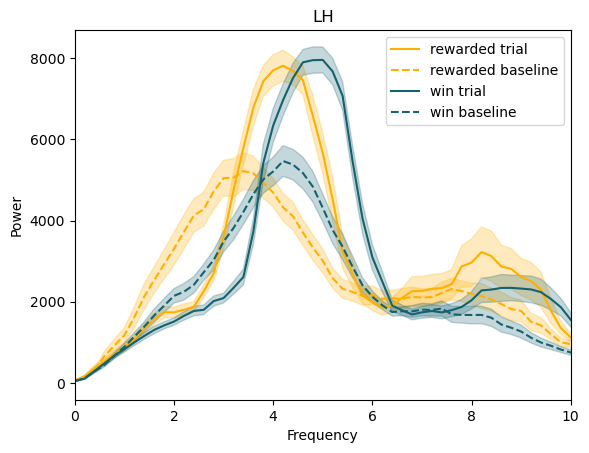

14
win


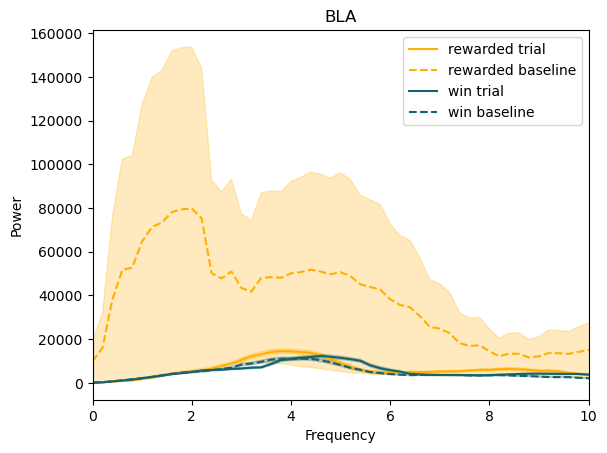

15
win


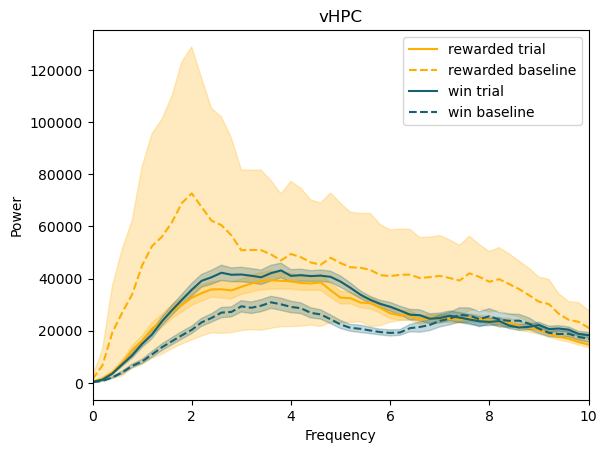

16
win


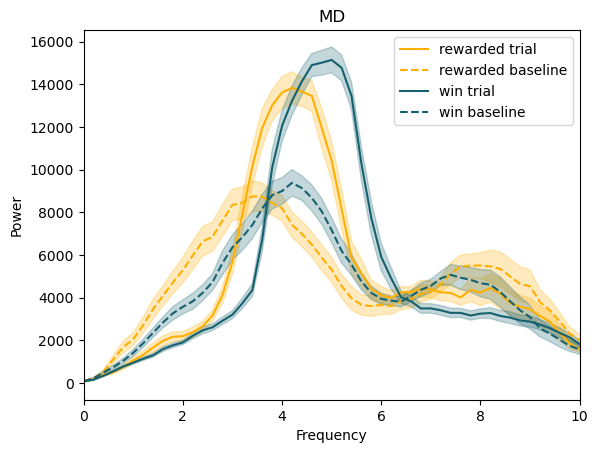

21
win


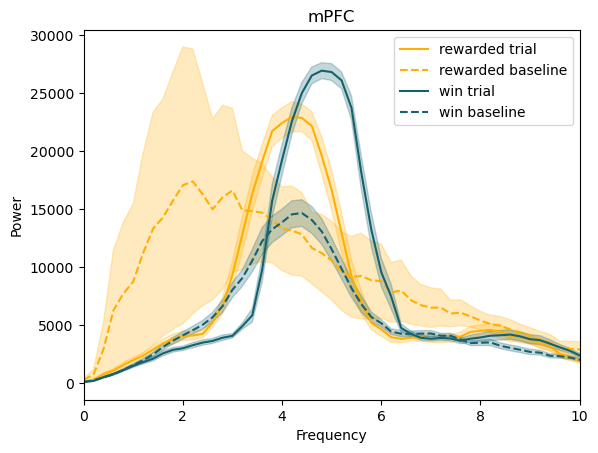

In [53]:
for channel in channel_id_to_brain_region.keys():
    print(channel)
    print(trial_type)

    fig, ax = plt.subplots()
    for trial_type in trials_with_reward:
        ax.plot(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="{} trial".format(trial_type), linestyle="-", color=trial_type_to_color[trial_type])
        ax.fill_between(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])

        ax.plot(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="{} baseline".format(trial_type), linestyle="--", color=trial_type_to_color[trial_type])
        ax.fill_between(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    plt.title("{}".format(channel_id_to_brain_region[channel]))
    ax.legend()
    
    plt.show()
#     ax.set_title("LFP Frequency vs Power for {}".format(channel))
#     plt.savefig("./proc/plots/lfp/power_vs_frequency_channel/lfp_{}_{}_20221214_rewarded_regular.png".format(subject_id, channel))

13
win


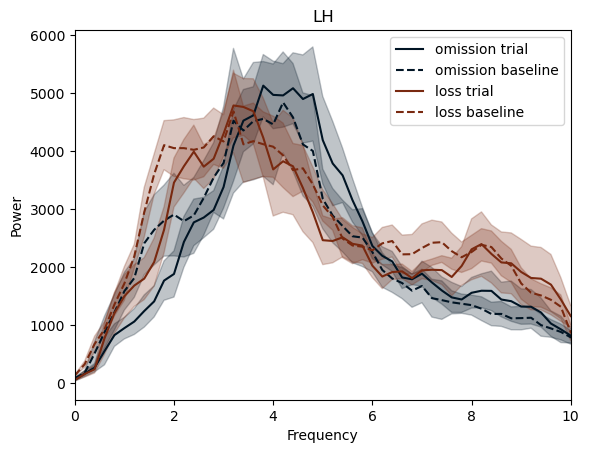

14
loss


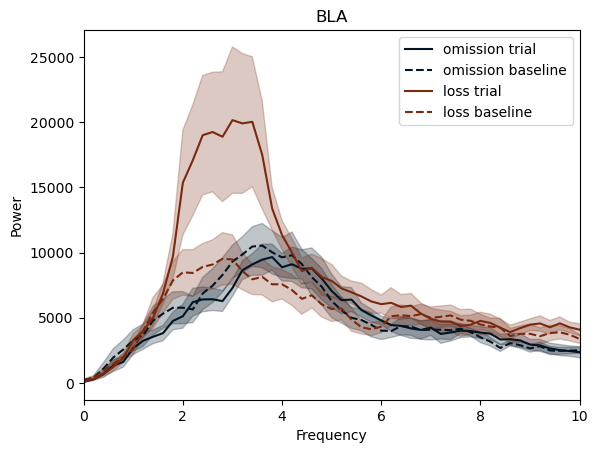

15
loss


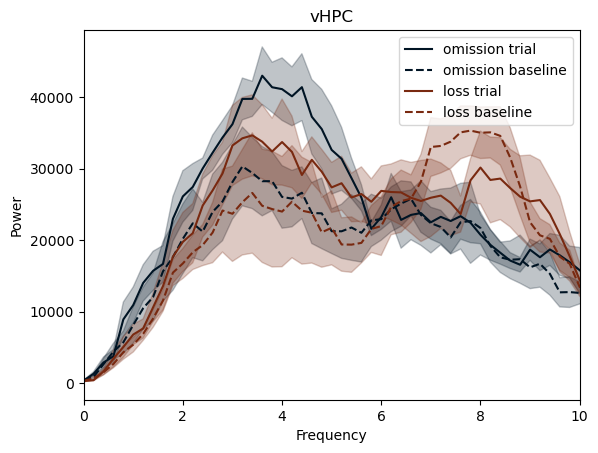

16
loss


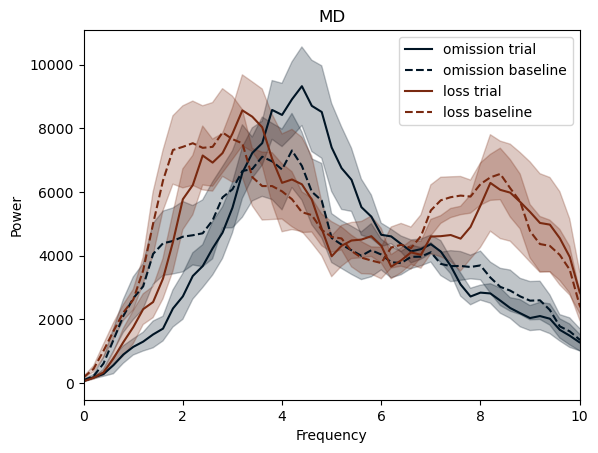

21
loss


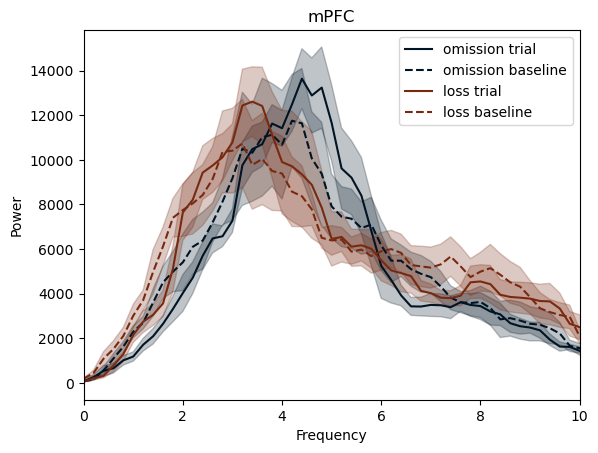

In [54]:
for channel in channel_id_to_brain_region.keys():
    print(channel)
    print(trial_type)

    fig, ax = plt.subplots()
    for trial_type in trials_without_reward:
        ax.plot(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="{} trial".format(trial_type), linestyle="-", color=trial_type_to_color[trial_type])
        ax.fill_between(frequencies, trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            trial_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+trial_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])

        ax.plot(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="{} baseline".format(trial_type), linestyle="--", color=trial_type_to_color[trial_type])
        ax.fill_between(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                            baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[trial_type])
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    plt.title("{}".format(channel_id_to_brain_region[channel]))
    ax.legend()
    
    plt.show()
#     ax.set_title("LFP Frequency vs Power for {}".format(channel))
#     plt.savefig("./proc/plots/lfp/power_vs_frequency_channel/lfp_{}_{}_20221214_rewarded_regular.png".format(subject_id, channel))

# Brain regions to use

In [ ]:
mPFC
LH
MD

In [ ]:
raise ValueError()

# REST IS OLD TEXT

# Step 0: Get the timestamps of the tone labels

In [ ]:
tone_label_path = glob.glob("./proc/*tone_label*")[0]

In [ ]:
tone_label_path

In [ ]:
tone_label_df = pd.read_csv(tone_label_path, index_col=0)

In [ ]:
tone_label_df["resampled_timestamps"] = (tone_label_df["tone_time_stamp"] * original_to_resampled_frequency_ratio).astype(int)

In [ ]:
tone_label_df.head()

In [ ]:
tone_label_df.tail()

# Step 1: Get the recording snippit

In [ ]:
example_channel = "21"

In [ ]:
channel_id_to_brain_region[example_channel]

- Getting the number of frames we're interested
    - This would be: `duration(s) * resampled_frequency(timestamp/s)`

In [ ]:
resampled_frequency

In [ ]:
duration = 5

- Getting the timestamp of the tone

In [ ]:
example_timestamp = tone_label_df["resampled_timestamps"].loc[0]

In [ ]:
example_timestamp

- Getting the traces for the baseline
    - -5 to 0 seconds to the tone

In [ ]:
example_baseline_traces = recording_intermediate.get_traces(channel_ids=[example_channel], start_frame=example_timestamp - (duration * resampled_frequency), end_frame=example_timestamp)

- Getting the traces for the trial
    - 5 to 10 seconds to the tone

In [ ]:
example_trial_traces = recording_intermediate.get_traces(channel_ids=[example_channel], start_frame=example_timestamp + (duration * resampled_frequency), end_frame=example_timestamp + (2 * duration * resampled_frequency))

# Plotting Power and Coherence

In [ ]:
time_halfbandwidth_product = 5

In [ ]:
# Compute multitaper spectral estimate
m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=example_trial_traces,
               sampling_frequency=resampled_frequency)



In [ ]:
# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)



In [ ]:
# Here are a couple of examples
power = c.power() # spectral power

In [ ]:
power.max()

In [ ]:
power.min()

- Test Code

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,200)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,30)

In [ ]:
c.power().squeeze()

In [ ]:
c.frequencies

## Getting the Power and Frequencies for all the categories and channels

In [ ]:
import itertools

In [ ]:
channel_id_to_brain_region = {"13": "LH", "14": "BLA", "15": "vHPC", "16":"MD", "21": "mPFC"}

In [ ]:
trial_type_to_color = {"rewarded": "#FFAF00", "win": "#15616F", "omission": "#001424", "loss": "#792910"}

In [ ]:
subject_id = "6.1"

In [ ]:
duration

In [ ]:
resampled_frequency

In [ ]:
resampled_frequency*duration

# TODO: figure out how to fix trial types with only one trial for mean and ste calculation

In [ ]:
baseline_to_ch_to_trial_type = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
trial_to_ch_to_trial_type = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# iterating through each channel and trial type combination
for index, (channel, trial_type) in enumerate(itertools.product(channel_id_to_brain_region.keys(), tone_label_df["tone_category"].unique())):
    print("Index: {}, Channel: {} Trial Type: {}".format(index, channel, trial_type))
    for time_stamp in tone_label_df[tone_label_df["tone_category"] == trial_type]["resampled_timestamps"]: 
        print("Timestamp: {}".format(time_stamp))
        baseline_traces = recording_intermediate.get_traces(channel_ids=[channel], start_frame=time_stamp - (duration * resampled_frequency), end_frame=time_stamp)
        trial_traces = recording_intermediate.get_traces(channel_ids=[channel], start_frame=time_stamp + (duration * resampled_frequency), end_frame=time_stamp + (2 * duration * resampled_frequency))
#         if baseline_traces.shape[0] < resampled_frequency*duration or trial_traces.shape[0] < resampled_frequency*duration:
#             continue
        print(baseline_traces.shape)
        print(trial_traces.shape)
        # Making sure everything is same number
        baseline_traces = baseline_traces[:resampled_frequency*duration] 
        trial_traces = trial_traces[:resampled_frequency*duration] 
        print("power calculation")
        # Compute multitaper spectral estimate
        baseline_m = Multitaper(time_series=baseline_traces, sampling_frequency=resampled_frequency, time_halfbandwidth_product=time_halfbandwidth_product)
        trial_m = Multitaper(time_series=trial_traces, sampling_frequency=resampled_frequency, time_halfbandwidth_product=time_halfbandwidth_product)
        # Sets up computing connectivity measures/power from multitaper spectral estimate
        baseline_c = Connectivity.from_multitaper(baseline_m)
        trial_c = Connectivity.from_multitaper(trial_m)
        # Adding the frequency and power to the list
        baseline_to_ch_to_trial_type[channel][trial_type]["power_list"].append(baseline_c.power().squeeze())
        baseline_to_ch_to_trial_type[channel][trial_type]["frequency_list"].append(baseline_c.frequencies)
        trial_to_ch_to_trial_type[channel][trial_type]["power_list"].append(trial_c.power().squeeze())
        trial_to_ch_to_trial_type[channel][trial_type]["frequency_list"].append(trial_c.frequencies) 
    print("aggregation")
    """
    # Making a list of list if there's only one list
    if len(baseline_to_ch_to_trial_type[channel][trial_type]["power_list"]) <= 1:
        baseline_to_ch_to_trial_type[channel][trial_type]["power_list"] = [baseline_to_ch_to_trial_type[channel][trial_type]["power_list"]]
        baseline_to_ch_to_trial_type[channel][trial_type]["frequency_list"] = [baseline_to_ch_to_trial_type[channel][trial_type]["frequency_list"]]

    if len(trial_to_ch_to_trial_type[channel][trial_type]["power_list"]) <= 1:
        trial_to_ch_to_trial_type[channel][trial_type]["power_list"] = [trial_to_ch_to_trial_type[channel][trial_type]["power_list"]]
        trial_to_ch_to_trial_type[channel][trial_type]["frequency_list"] = [trial_to_ch_to_trial_type[channel][trial_type]["frequency_list"]]
    """
        
    baseline_to_ch_to_trial_type[channel][trial_type]["traces_array"] = np.vstack(baseline_to_ch_to_trial_type[channel][trial_type]["power_list"])
    baseline_to_ch_to_trial_type[channel][trial_type]["mean_traces_array"] = np.mean(baseline_to_ch_to_trial_type[channel][trial_type]["traces_array"], axis = 0)
    baseline_to_ch_to_trial_type[channel][trial_type]["ste_traces_array"] = stats.sem(baseline_to_ch_to_trial_type[channel][trial_type]["traces_array"])

    trial_to_ch_to_trial_type[channel][trial_type]["traces_array"] = np.vstack(trial_to_ch_to_trial_type[channel][trial_type]["power_list"])
    trial_to_ch_to_trial_type[channel][trial_type]["mean_traces_array"] = np.mean(trial_to_ch_to_trial_type[channel][trial_type]["traces_array"], axis = 0)
    trial_to_ch_to_trial_type[channel][trial_type]["ste_traces_array"] = stats.sem(trial_to_ch_to_trial_type[channel][trial_type]["traces_array"])

In [ ]:
baseline_df = pd.DataFrame.from_dict({(i,j): baseline_to_ch_to_trial_type[i][j] 
                           for i in baseline_to_ch_to_trial_type.keys() 
                           for j in baseline_to_ch_to_trial_type[i].keys()},
                       orient='index')

In [ ]:
trial_df = pd.DataFrame.from_dict({(i,j): trial_to_ch_to_trial_type[i][j] 
                           for i in trial_to_ch_to_trial_type.keys() 
                           for j in trial_to_ch_to_trial_type[i].keys()},
                       orient='index')

In [ ]:
baseline_pickle_base = os.path.splitext(os.path.basename(tone_label_path))[0].strip("tone_label_df").strip("_")
baseline_pickle_name = "baseline_{}.pickle".format(baseline_pickle_base)

In [ ]:
baseline_pickle_name

In [ ]:
baseline_df.to_pickle(os.path.join("./proc", baseline_pickle_name))

In [ ]:
trial_pickle_base = os.path.splitext(os.path.basename(tone_label_path))[0].strip("tone_label_df").strip("_")
trial_pickle_name = "trial_{}.pickle".format(trial_pickle_base)

In [ ]:
trial_pickle_name

In [ ]:
trial_df.to_pickle(os.path.join("./proc", trial_pickle_name))

In [ ]:
trial_df

In [ ]:
pd.read_pickle(os.path.join("./proc", trial_pickle_name)).head()

In [ ]:
raise ValueError()

### Syncing up with the Winning Labels

In [ ]:
winning_resampled_timestamps = tone_label_df[tone_label_df["tone_category"] == "win"]["resampled_timestamps"]

In [ ]:
winning_resampled_timestamps

- Power reduces shape from 10000 to 5000

In [ ]:
winning_power_list = []
winning_frequencies_list = []
for time_stamp in winning_resampled_timestamps:
    
    # Compute multitaper spectral estimate
    m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=recording_intermediate.get_traces(channel_ids=["21"], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*10))

    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    winning_power_list.append(c.power().squeeze())
#     winning_frequencies_list.append(c.frequencies)

    

In [ ]:
winning_traces_array = np.vstack(winning_power_list)

In [ ]:
winning_traces_array.shape

In [ ]:
c.frequencies.shape

In [ ]:
c.frequencies

In [ ]:
c.power().squeeze().shape

In [ ]:
np.mean(winning_traces_array, axis = 0)

In [ ]:
winning_traces_array[0]

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
mean_traces_array = np.mean(winning_traces_array, axis = 0)
ste_traces_array = stats.sem(winning_traces_array)


ax.plot(c.frequencies, np.mean(winning_traces_array, axis = 0))
ax.fill_between(c.frequencies, np.mean(winning_traces_array, axis = 0)-ste_traces_array, \
                    np.mean(winning_traces_array, axis = 0)+ste_traces_array, \
                   alpha=.25, color="r")
ax.set_xlim(0,80)
# ax.set_yscale("log")
ax.set_ylim(0,60000)

## All the trial types with mPFC channel

In [ ]:
tone_label_df

In [ ]:
tone_label_to_timestamps = defaultdict(dict)
for tone_label in tone_label_df["tone_category"].unique():
    tone_label_to_timestamps[tone_label]["resampled_timestamps"] = tone_label_df[tone_label_df["tone_category"] == tone_label]["resampled_timestamps"]

In [ ]:
duration = 10
for tone_label in tone_label_df["tone_category"].unique():
    print(tone_label)
    tone_label_to_timestamps[tone_label]["power_list"] = []
    tone_label_to_timestamps[tone_label]["frequency_list"] = []

    for time_stamp in tone_label_to_timestamps[tone_label]["resampled_timestamps"]:
        recording_traces = recording_intermediate.get_traces(channel_ids=["21"], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*duration)
        # Making sure everything is same number
        recording_traces = recording_traces[:resampled_frequency*duration]        
        # Compute multitaper spectral estimate
        m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency, time_halfbandwidth_product=time_halfbandwidth_product)

        # Sets up computing connectivity measures/power from multitaper spectral estimate
        c = Connectivity.from_multitaper(m)
        tone_label_to_timestamps[tone_label]["power_list"].append(c.power().squeeze())
        tone_label_to_timestamps[tone_label]["frequency_list"].append(c.frequencies)
        # To see if everything is shaped correctly
        print(c.power().squeeze().shape)
        print(c.frequencies.shape)
#         break

    tone_label_to_timestamps[tone_label]["traces_array"] = np.vstack(tone_label_to_timestamps[tone_label]["power_list"])
    tone_label_to_timestamps[tone_label]["mean_traces_array"] = np.mean(tone_label_to_timestamps[tone_label]["traces_array"], axis = 0)
    tone_label_to_timestamps[tone_label]["ste_traces_array"] = stats.sem(tone_label_to_timestamps[tone_label]["traces_array"])
#     break

### Calculating the baseline activity

In [ ]:
baseline_tone_label_to_timestamps = defaultdict(dict)
for tone_label in tone_label_df["tone_category"].unique():
    baseline_tone_label_to_timestamps[tone_label]["resampled_timestamps"] = tone_label_df[tone_label_df["tone_category"] == tone_label]["resampled_timestamps"]

In [ ]:
duration = 10
for tone_label in tone_label_df["tone_category"].unique():
    print(tone_label)
    baseline_tone_label_to_timestamps[tone_label]["power_list"] = []
    baseline_tone_label_to_timestamps[tone_label]["frequency_list"] = []

    for time_stamp in baseline_tone_label_to_timestamps[tone_label]["resampled_timestamps"]:
        recording_traces = recording_intermediate.get_traces(channel_ids=["21"], start_frame=time_stamp-resampled_frequency*duration, end_frame=time_stamp)
        # Making sure everything is same number
        recording_traces = recording_traces[:resampled_frequency*duration]        
        # Compute multitaper spectral estimate
        m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency, time_halfbandwidth_product=time_halfbandwidth_product)

        # Sets up computing connectivity measures/power from multitaper spectral estimate
        c = Connectivity.from_multitaper(m)
        baseline_tone_label_to_timestamps[tone_label]["power_list"].append(c.power().squeeze())
        baseline_tone_label_to_timestamps[tone_label]["frequency_list"].append(c.frequencies)
        # To see if everything is shaped correctly
        print(c.power().squeeze().shape)
        print(c.frequencies.shape)
#         break

    baseline_tone_label_to_timestamps[tone_label]["traces_array"] = np.vstack(baseline_tone_label_to_timestamps[tone_label]["power_list"])
    baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"] = np.mean(baseline_tone_label_to_timestamps[tone_label]["traces_array"], axis = 0)
    baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"] = stats.sem(baseline_tone_label_to_timestamps[tone_label]["traces_array"])
#     break

In [ ]:
tone_label_to_timestamps

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in tone_label_df["tone_category"].unique():


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label=tone_label)
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25)
ax.set_xlim(0,80)
ax.set_yscale("log")
# ax.set_ylim(0,60000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
tone_label_df["tone_category"].unique()

In [ ]:
trials_with_reward = ['rewarded', 'win']

In [ ]:
trials_without_reward = ['omission', 'loss']

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in trials_with_reward:


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25, color=trial_type_to_color[tone_label])
    
    ax.plot(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]-baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]+baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25, color=trial_type_to_color[tone_label])
    
ax.set_xlim(0,10)
# ax.set_yscale("log")
ax.set_ylim(0,40000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in trials_without_reward:


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.1, color=trial_type_to_color[tone_label])
    
    ax.plot(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]-baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]+baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.1, color=trial_type_to_color[tone_label])
    
ax.set_xlim(0,10)
# ax.set_yscale("log")
ax.set_ylim(0,40000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in tone_label_df["tone_category"].unique():


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} trial".format(tone_label))
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25)
    
ax.set_xlim(0,15)
# ax.set_yscale("log")
ax.set_ylim(0,40000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

## Making plots for all brain regions

In [ ]:
channel_id_to_brain_region

In [ ]:
tone_label_df.head()

- Getting the timestamps for each trial

In [ ]:
tone_label_to_timestamps = {}
for tone_label in tone_label_df["tone_category"].unique():
        tone_label_to_timestamps[tone_label] = tone_label_df[tone_label_df["tone_category"] == tone_label]["resampled_timestamps"]

In [ ]:
tone_label_to_timestamps

- Getting the traces and relevant stats for during the trial

In [ ]:
duration = 15

brain_region_to_during_tone_label_to_traces = defaultdict(dict)
for channel, brain_region in channel_id_to_brain_region.items():
    print("Channel: {}".format(channel))
    brain_region_to_during_tone_label_to_traces[brain_region] = defaultdict(dict)
    for tone_label in tone_label_df["tone_category"].unique():
        print(tone_label)
                
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"] = []
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["frequency_list"] = []

        for time_stamp in tone_label_to_timestamps[tone_label]:
            recording_traces = recording_intermediate.get_traces(channel_ids=[channel], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*duration)
            # Making sure everything is same number
            recording_traces = recording_traces[:resampled_frequency*duration]        
            # Compute multitaper spectral estimate
            m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency, time_halfbandwidth_product=time_halfbandwidth_product)
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m)
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"].append(c.power().squeeze())
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["frequency_list"].append(c.frequencies)
            # To see if everything is shaped correctly
            print(c.power().squeeze().shape)
            print(c.frequencies.shape)

        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"] = np.vstack(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"])
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"] = np.mean(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"], axis = 0)
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"] = stats.sem(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"])


- Getting the traces and relevant stats for before the trial

In [ ]:
duration = 15

brain_region_to_before_tone_label_to_traces = defaultdict(dict)
for channel, brain_region in channel_id_to_brain_region.items():
    print("Channel: {}".format(channel))
    brain_region_to_before_tone_label_to_traces[brain_region] = defaultdict(dict)
    for tone_label in tone_label_df["tone_category"].unique():
        print(tone_label)
        
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"] = []
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["frequency_list"] = []

        for time_stamp in tone_label_to_timestamps[tone_label]:
            recording_traces = recording_intermediate.get_traces(channel_ids=[channel], start_frame=time_stamp-resampled_frequency*duration, end_frame=time_stamp)
            # Making sure everything is same number
            recording_traces = recording_traces[:resampled_frequency*duration]        
            # Compute multitaper spectral estimate
            m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency, time_halfbandwidth_product=time_halfbandwidth_product)
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m)
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"].append(c.power().squeeze())
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["frequency_list"].append(c.frequencies)
            # To see if everything is shaped correctly
            print(c.power().squeeze().shape)
            print(c.frequencies.shape)

        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"] = np.vstack(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"])
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"] = np.mean(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"], axis = 0)
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"] = stats.sem(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"])


In [ ]:
brain_region_to_during_tone_label_to_traces["LH"]

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in tone_label_df["tone_category"].unique():


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label=tone_label)
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25)
ax.set_xlim(0,80)
ax.set_yscale("log")
# ax.set_ylim(0,60000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
trials_with_reward = ['rewarded', 'win']

In [ ]:
trials_without_reward = ['omission', 'loss']

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_with_reward:
        print(tone_label)

        ax.plot(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

        ax.plot(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
    ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {}".format(brain_region))
    plt.savefig("./proc/plots/lfp/power_vs_frequency_brain_region/lfp_{}_{}_20221214_rewarded_regular.png".format(subject_id, brain_region))

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:


        ax.plot(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

        ax.plot(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
    ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {}".format(brain_region))
        plt.savefig("./proc/plots/lfp/power_vs_frequency_brain_region/lfp_{}_{}_20221214_rewarded_regular.png".format(subject_id, brain_region))

## Adding curving to the line

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline


In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:
def get_smoothed_x_and_y(x_array, y_array, number_of_points=None):
    """
    """
    if number_of_points is None:
        number_of_points = len(x_array) // 10
    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(x_array.min(), x_array.max(), number_of_points) 

    spl = make_interp_spline(x_array, y_array, k=3)  # type: BSpline
    return xnew, spl(xnew)

In [ ]:
number_of_points = 3750

In [ ]:
number_of_points = 750

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_with_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
#     ax.set_ylim(0,65000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    plt.savefig("./proc/plots/lfp/power_vs_frequency_brain_region/lfp_{}_{}_20221214_rewarded_smoothed.png".format(subject_id, brain_region))

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
#     ax.set_ylim(0,65000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    plt.savefig("./proc/plots/lfp/power_vs_frequency_brain_region/lfp_{}_{}_20221214_omitted_smoothed.png".format(subject_id, brain_region))

# Looking at all the channels

- Looking into why the channels for mPFC and MD are so similar

In [ ]:
recording_intermediate.channel_ids

In [ ]:
all_channel_id_to_brain_region = {}
for channel in recording_intermediate.channel_ids:
    all_channel_id_to_brain_region[channel] = channel_id_to_brain_region.get(channel, "mPFC")

In [ ]:
all_channel_id_to_brain_region

- Getting the timestamps for each trial

In [ ]:
tone_label_to_timestamps

- Getting the traces and relevant stats for during the trial

In [ ]:
duration = 15

channel_to_during_tone_label_to_traces = defaultdict(dict)
for channel, brain_region in all_channel_id_to_brain_region.items():
    print("Channel: {}".format(channel))
    channel_to_during_tone_label_to_traces[channel] = defaultdict(dict)
    for tone_label in tone_label_df["tone_category"].unique():
        print(tone_label)
                
        channel_to_during_tone_label_to_traces[channel][tone_label]["power_list"] = []
        channel_to_during_tone_label_to_traces[channel][tone_label]["frequency_list"] = []

        for time_stamp in tone_label_to_timestamps[tone_label]:
            recording_traces = recording_intermediate.get_traces(channel_ids=[channel], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*duration)
            # Making sure everything is same number
            recording_traces = recording_traces[:resampled_frequency*duration]        
            # Compute multitaper spectral estimate
            m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency, time_halfbandwidth_product=time_halfbandwidth_product)
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m)
            channel_to_during_tone_label_to_traces[channel][tone_label]["power_list"].append(c.power().squeeze())
            channel_to_during_tone_label_to_traces[channel][tone_label]["frequency_list"].append(c.frequencies)
            # To see if everything is shaped correctly
            print(c.power().squeeze().shape)
            print(c.frequencies.shape)

        channel_to_during_tone_label_to_traces[channel][tone_label]["traces_array"] = np.vstack(channel_to_during_tone_label_to_traces[channel][tone_label]["power_list"])
        channel_to_during_tone_label_to_traces[channel][tone_label]["mean_traces_array"] = np.mean(channel_to_during_tone_label_to_traces[channel][tone_label]["traces_array"], axis = 0)
        channel_to_during_tone_label_to_traces[channel][tone_label]["ste_traces_array"] = stats.sem(channel_to_during_tone_label_to_traces[channel][tone_label]["traces_array"])


- Getting the traces and relevant stats for before the trial

In [ ]:
duration = 15

channel_to_before_tone_label_to_traces = defaultdict(dict)
for channel, brain_region in all_channel_id_to_brain_region.items():
    print("Channel: {}".format(channel))
    channel_to_before_tone_label_to_traces[channel] = defaultdict(dict)
    for tone_label in tone_label_df["tone_category"].unique():
        print(tone_label)
                
        channel_to_before_tone_label_to_traces[channel][tone_label]["power_list"] = []
        channel_to_before_tone_label_to_traces[channel][tone_label]["frequency_list"] = []

        for time_stamp in tone_label_to_timestamps[tone_label]:
            recording_traces = recording_intermediate.get_traces(channel_ids=[channel], start_frame=time_stamp-resampled_frequency*duration, end_frame=time_stamp)
            # Making sure everything is same number
            recording_traces = recording_traces[:resampled_frequency*duration]        
            # Compute multitaper spectral estimate
            m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency, time_halfbandwidth_product=time_halfbandwidth_product)
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m)
            channel_to_before_tone_label_to_traces[channel][tone_label]["power_list"].append(c.power().squeeze())
            channel_to_before_tone_label_to_traces[channel][tone_label]["frequency_list"].append(c.frequencies)
            # To see if everything is shaped correctly
            print(c.power().squeeze().shape)
            print(c.frequencies.shape)

        channel_to_before_tone_label_to_traces[channel][tone_label]["traces_array"] = np.vstack(channel_to_before_tone_label_to_traces[channel][tone_label]["power_list"])
        channel_to_before_tone_label_to_traces[channel][tone_label]["mean_traces_array"] = np.mean(channel_to_before_tone_label_to_traces[channel][tone_label]["traces_array"], axis = 0)
        channel_to_before_tone_label_to_traces[channel][tone_label]["ste_traces_array"] = stats.sem(channel_to_before_tone_label_to_traces[channel][tone_label]["traces_array"])


In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in tone_label_df["tone_category"].unique():


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label=tone_label)
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25)
ax.set_xlim(0,80)
ax.set_yscale("log")
# ax.set_ylim(0,60000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
trials_with_reward = ['rewarded', 'win']

In [ ]:
trials_without_reward = ['omission', 'loss']

In [ ]:
for channel, during_tone_label_to_traces in channel_to_before_tone_label_to_traces.items():
    print(channel)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_with_reward:
        print(tone_label)

        ax.plot(c.frequencies, channel_to_during_tone_label_to_traces[channel][tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, channel_to_during_tone_label_to_traces[channel][tone_label]["mean_traces_array"]-channel_to_during_tone_label_to_traces[channel][tone_label]["ste_traces_array"], \
                            channel_to_during_tone_label_to_traces[channel][tone_label]["mean_traces_array"]+channel_to_during_tone_label_to_traces[channel][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

        ax.plot(c.frequencies, channel_to_before_tone_label_to_traces[channel][tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, channel_to_before_tone_label_to_traces[channel][tone_label]["mean_traces_array"]-channel_to_before_tone_label_to_traces[channel][tone_label]["ste_traces_array"], \
                            channel_to_before_tone_label_to_traces[channel][tone_label]["mean_traces_array"]+channel_to_before_tone_label_to_traces[channel][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
    ax.set_ylim(0, 60000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {}".format(channel))
    plt.savefig("./proc/plots/lfp/power_vs_frequency_regular/lfp_pow_freq_{}_ch_{}_20221214_with_reward.png".format(subject_id, channel))

In [ ]:
for channel, during_tone_label_to_traces in channel_to_before_tone_label_to_traces.items():
    print(channel)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:
        print(tone_label)

        ax.plot(c.frequencies, channel_to_during_tone_label_to_traces[channel][tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, channel_to_during_tone_label_to_traces[channel][tone_label]["mean_traces_array"]-channel_to_during_tone_label_to_traces[channel][tone_label]["ste_traces_array"], \
                            channel_to_during_tone_label_to_traces[channel][tone_label]["mean_traces_array"]+channel_to_during_tone_label_to_traces[channel][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

        ax.plot(c.frequencies, channel_to_before_tone_label_to_traces[channel][tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, channel_to_before_tone_label_to_traces[channel][tone_label]["mean_traces_array"]-channel_to_before_tone_label_to_traces[channel][tone_label]["ste_traces_array"], \
                            channel_to_before_tone_label_to_traces[channel][tone_label]["mean_traces_array"]+channel_to_before_tone_label_to_traces[channel][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
    ax.set_ylim(0, 60000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {}".format(channel))
    plt.savefig("./proc/plots/lfp/power_vs_frequency_regular/lfp_pow_freq_{}_ch_{}_20221214_without_reward.png".format(subject_id, channel))

## Adding curving to the line

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline


In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:


plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
def get_smoothed_x_and_y(x_array, y_array, number_of_points=None):
    """
    """
    if number_of_points is None:
        number_of_points = len(x_array) // 10
    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(x_array.min(), x_array.max(), number_of_points) 

    spl = make_interp_spline(x_array, y_array, k=3)  # type: BSpline
    return xnew, spl(xnew)

In [ ]:
number_of_points = 3750

In [ ]:
number_of_points = 750

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_with_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
    ax.set_ylim(0,65000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    plt.savefig("lfp_{}_{}_20221214_rewarded.png".format(subject_id, brain_region))

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
    ax.set_ylim(0,65000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    plt.savefig("lfp_{}_{}_20221214_unrewarded.png".format(subject_id, brain_region))

In [ ]:
raise ValueError()

# Part 4: Saving the Preprocessed files to folder

- Seeing which recording directories are already made

In [ ]:
all_parent_recording_directories = glob.glob("./proc/*")

In [ ]:
all_parent_recording_directories

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [ ]:
parent_output_directory = all_parent_recording_directories[0]

- Creating a directory within the recording directory for preprocessing and saving the preprocessed recordings into it 

In [ ]:
preprocessing_output_directory = os.path.join(parent_output_directory, "preprocessing")


In [ ]:
if not os.path.exists(preprocessing_output_directory):
    recording_intermediate.save_to_folder(name="preprocessing", folder=preprocessing_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(preprocessing_output_directory))

- Testing to see if everything was loaded correctly

In [ ]:
recording_test = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessing_output_directory)


In [ ]:
sw.plot_timeseries(recording_test, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)


In [ ]:
probe_group = recording_test.get_probegroup()

In [ ]:
plot_probe_group(probe_group, same_axes=False, with_channel_index=True)
plt.show()

# Other options and things to look at

In [ ]:
raise ValueError("Cells below are other options for preprocessing steps and visualizations. They take time and are still being tested, so running the rest of the notebook is not necessary. They are for those that want to look further into the recording data and the the preprocessing steps.")

## Computing Local Field Potential and Multi-Unit Activity

- "Local field potentials (LFP) are low frequency components of the extracellular recordings." 
- "Multi-unit activity (MUA) are rectified and low-pass filtered recordings showing the diffuse spiking activity."
    - https://spikeinterface.readthedocs.io/en/0.13.0/modules/toolkit/plot_1_preprocessing.html

In [ ]:
recording_lfp = st.preprocessing.bandpass_filter(recording_raw, freq_min=1, freq_max=300)
recording_mua = st.preprocessing.rectify(recording_raw)

In [ ]:
recording_lfp

In [ ]:
recording_mua

In [ ]:
f_lfp, p_lfp = scipy.signal.welch(recording_lfp.get_traces(segment_index=0)[:, 0], fs=fs)


In [ ]:
f_mua, p_mua = scipy.signal.welch(recording_mua.get_traces(segment_index=0)[:, 0], fs=fs)


In [ ]:
fig, ax = plt.subplots()
ax.semilogy(f_lfp, p_lfp, label="Local Field Potential")
ax.semilogy(f_mua, p_mua, label="Multi-Unit Activity")

plt.xlabel("Sample Frequencies")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density of Preprocessing Techniques")
plt.legend()
plt.show()

### Plotting Power Spectrum

- Now let’s plot the power spectrum of non-filtered, bandpass filtered, and notch filtered recordings.

In [ ]:
# The sampling frequency of the recording
fs = recording_raw.get_sampling_frequency()
fs

- Getting the power spectral density using Welch’s method for 0th segment
    - To access a given channel, index it like this: `recording_raw_traces[:, 0]` (0 is the number of the channel)
    - Commented out code is already ran, and the output is saved to a file to save time. Ur having issues with Jupyter Notebook not dying while running

In [ ]:
f_raw, p_raw = scipy.signal.welch(recording_raw.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_bandpass, p_bandpass = scipy.signal.welch(recording_bandpass.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_remove_bad_channels, p_remove_bad_channels = scipy.signal.welch(recording_remove_bad_channels.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_common_reference, p_common_reference = scipy.signal.welch(recording_common_reference.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_notch, p_notch = scipy.signal.welch(recording_notch.get_traces(segment_index=0)[:, 0], fs=fs)

- Plotting the power spectral density(https://en.wikipedia.org/wiki/Spectral_density)
    - Plotting the Semilog (https://www.mathworks.com/help/matlab/ref/semilogy.html) which plots the y-axis as powers of 10's
    - The X axis is the "Array of sample frequencies."
    - The Y axis is the "Power spectral density or power spectrum of X"
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html


In [ ]:
fig, ax = plt.subplots()
ax.semilogy(f_raw, p_raw, label="Raw")
ax.semilogy(f_bandpass, p_bandpass, label="Bandpass")
ax.semilogy(f_notch, p_notch, label="Notch")
ax.semilogy(f_remove_bad_channels, p_remove_bad_channels, label="Remove Bad Channels")
ax.semilogy(f_common_reference, p_common_reference, label="Common Reference")

plt.xlabel("Sample Frequencies")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density of Preprocessing Techniques")
plt.legend()
plt.show()

## Changing the Reference

- Rereferencing the signal to reduce the common mode noise from the recording
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_1_preprocessing.html
- Average/median can be computed on different groups. 
- Single channels can also be used as reference.

In [ ]:
recording_car = st.common_reference(recording_raw, reference='global', operator='average')
recording_cmr = st.common_reference(recording_raw, reference='global', operator='median')

- Changing the reference and getting the reference causes the memory to run out of the computer so, commented out

In [ ]:
car_traces = recording_car.get_traces(segment_index=0)[:, 0]

In [ ]:
cmr_traces = recording_cmr.get_traces(segment_index=0)[:, 0]

In [ ]:
    else:
        metadata_exists = False
        warnings.warn("""No metadata was able to be extracted out of the file. 
    Either edit the code block above to match your format.
    Or change the format of the metadata to match something similar like these lines:  

    Description: Channel info for PHY data
    Byte_order: little endian
    Original_file: 02172021_BLA4-1_3_Competition_Rec.rec
    Clock rate: 20000
    Decimation: 1
    Number_of_channels: 32
    Fields: <nTrode int16><nTrodeChannel int16>")
    """)remove_bad_channelsfig, ax = plt.subplots()


ax.plot(car_traces, label = "Common average reference" )
ax.plot(cmr_traces, label = "Common median reference")
plt.legend()
plt.title("Title")
plt.xlabel("X Label")
plt.ylabel("Y Label")
plt.show()